# Beat Tracking Evaluation

This notebook runs the beat tracker in beat_tracker.py on all audio files in the dataset.
The results are then evaluated, and analyzed below.

In [63]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from beat_tracker import beatTracker, ellisBeatTracker
from mir_eval import beat

np.int = np.int64 #quickfix for mir_eval incompatible with numpy version

In [137]:
# Get a dictionary of filenames by dance type
ballroom_cat = os.listdir("BallroomData")

dir_dict = {}

for cat in ballroom_cat:
    if cat not in ['nada', 'allBallroomFiles'] :
        files = os.listdir(f"BallroomData/{cat}")
        dir_dict[cat] = files

dir_dict


{'Waltz': ['Media-105901.wav',
  'Albums-Step_By_Step-04.wav',
  'Media-104202.wav',
  'Media-104203.wav',
  'Media-105902.wav',
  'Media-104201.wav',
  'Media-104604.wav',
  'Albums-Step_By_Step-02.wav',
  'Media-104402.wav',
  'Media-104204.wav',
  'Media-104205.wav',
  'Albums-Step_By_Step-03.wav',
  'Media-104403.wav',
  'Media-104601.wav',
  'Media-104603.wav',
  'Media-104401.wav',
  'Albums-Step_By_Step-01.wav',
  'Albums-Commitments-11.wav',
  'Media-104602.wav',
  'Media-100601.wav',
  'Media-104301.wav',
  'Media-105802.wav',
  'Media-104705.wav',
  'Media-104704.wav',
  'Media-105803.wav',
  'Media-104302.wav',
  'Media-100602.wav',
  'Media-105801.wav',
  'Media-104504.wav',
  'Media-104303.wav',
  'Media-100603.wav',
  'Albums-Chrisanne2-01.wav',
  'Albums-Ballroom_Magic-18.wav',
  'Media-105804.wav',
  'Media-104501.wav',
  'Media-104703.wav',
  'Media-104702.wav',
  'Media-105805.wav',
  'Albums-Chrisanne2-02.wav',
  'Media-100604.wav',
  'Media-104502.wav',
  'Media-104

In [45]:
# Define evaulation helper function

def get_eval_metrics(ref_beats_trimmed, beats_trimmed, print_metrics=False):
    f_measure = beat.f_measure(ref_beats_trimmed, beats_trimmed, f_measure_threshold=0.07)
    cemgil_score, cemgil_max = beat.cemgil(ref_beats_trimmed, beats_trimmed)
    goto = beat.goto(ref_beats_trimmed, beats_trimmed)
    p_score = beat.p_score(ref_beats_trimmed, beats_trimmed)
    info_gain = beat.information_gain(ref_beats_trimmed, beats_trimmed)
    CMLc, CMLt, AMLc, AMlt = beat.continuity(ref_beats_trimmed, beats_trimmed)

    metrics = {
        "f_measure": f_measure,
        "cemgil_score": cemgil_score,
        "cemgil_max": cemgil_max,
        "goto": goto,
        "p_score": p_score,
        "info_gain": info_gain,
        "CMLc": CMLc,
        "CMLt": CMLt,
        "AMLc": AMLc,
        "AMlt": AMlt,
    }
    if print_metrics:
        print(f"Evaluation metrics:")
        print(f"F-measure (0.07 threshold) = {f_measure}")
        print(f"Cemgil's score: {cemgil_score}; Maximum Cemgil's score: {cemgil_max}")
        print(f"Goto's score: {goto}")
        print(f"P-score: {p_score}")
        print(f"Information Gain: {info_gain}")
        print(f"CMLc: {CMLc}; CMLt: {CMLt}; AMLc: {AMLc}; AMlt: {AMlt}")

    return metrics


def evaluate_beats(beats_trimmed, ref_beats_trimmed):

    beat.validate(ref_beats_trimmed, beats_trimmed)

    # Evaluate beat
    metrics_dict = get_eval_metrics(ref_beats_trimmed, beats_trimmed)
    return metrics_dict

    

## Run beat tracking on all files, and evaluate them

In [46]:
dfs = []

for cat, file_list in dir_dict.items():
    print(f"Beat tracking for category: {cat}")
    eval_metrics = []
    for filename in file_list:
        audio_filename = f"BallroomData/{cat}/{filename}"
        beats_filename = f"BallroomAnnotations-master/{filename[:-4]}.beats"

        with open(beats_filename) as my_file:
            testsite_array = my_file.readlines()
            ref_beats = np.array([float(val.split()[0]) for val in testsite_array])
            ref_beat_count = np.array([float(val.split()[1]) for val in testsite_array])
            ref_down_beats = ref_beats[ref_beat_count==1]
            meter = int(ref_beat_count.max())

        bt = ellisBeatTracker(metric=meter)
        beats, downbeats = bt(audio_filename)

        # Trim beats to 5 seconds and above
        beats_trimmed = beat.trim_beats(beats, min_beat_time=5.0)
        ref_beats_trimmed = beat.trim_beats(ref_beats, min_beat_time=5.0)
        downbeats_trimmed = beat.trim_beats(downbeats, min_beat_time=5.0)
        ref_down_beats_trimmed = beat.trim_beats(ref_down_beats, min_beat_time=5.0)

        metrics_dict = evaluate_beats(beats_trimmed, ref_beats_trimmed)
        downbeat_metrics_dict = evaluate_beats(downbeats_trimmed, ref_down_beats_trimmed)
        downbeat_metrics_dict = {f'{metric_name}_downbeat': val for metric_name, val in downbeat_metrics_dict.items()}
        metrics_dict.update(downbeat_metrics_dict)

        # Evaluate Tempo
        actual_tempo = (60/(ref_beats_trimmed[1:] - ref_beats_trimmed[:-1])).mean()
        actual_tempo_std = (60/(ref_beats_trimmed[1:] - ref_beats_trimmed[:-1])).std()
        metrics_dict.update({"actual_tempo": actual_tempo, 
                           "est_tempo": bt.tempo, 
                           "tempo_diff": bt.tempo - actual_tempo, 
                           "actual_tempo_std": actual_tempo_std,
                           "actual_vs_est_tempo_ratio": actual_tempo/bt.tempo,
                           "filename": filename,
                           "meter_downbeat": meter})

        # Add all metrics to list
        eval_metrics.append(metrics_dict)
    
    cat_metrics_df = pd.DataFrame(eval_metrics)
    cat_metrics_df['category'] = cat
    dfs.append(cat_metrics_df)


Beat tracking for category: Waltz
Beat tracking for category: VienneseWaltz
Beat tracking for category: ChaChaCha
Beat tracking for category: Rumba-American
Beat tracking for category: Jive
Beat tracking for category: Tango
Beat tracking for category: Samba
Beat tracking for category: Quickstep
Beat tracking for category: Rumba-Misc
Beat tracking for category: Rumba-International


## Format and explore results

In [47]:
results = pd.concat(dfs)

In [127]:
results.columns = [col.replace("downbeat", "db") for col in results.columns]
downbeat_cols = [col for col in results.columns if 'db' in col]

In [57]:
# Average results for beat detection and tempo est
results.drop(columns=downbeat_cols + ["filename", 'category']).mean().reset_index()

,index,0
0,f_measure,0.691739
1,cemgil_score,0.616754
2,cemgil_max,0.766748
3,goto,0.351003
4,p_score,0.628919
5,info_gain,0.450553
6,CMLc,0.338683
7,CMLt,0.361343
8,AMLc,0.733653
9,AMlt,0.799406


In [123]:
# Average results for downbeat detection
results[downbeat_cols].mean().reset_index()

,index,0
0,f_measure_downbeat,0.290554
1,cemgil_score_downbeat,0.257330
2,cemgil_max_downbeat,0.365534
3,goto_downbeat,0.153295
4,p_score_downbeat,0.384788
5,info_gain_downbeat,0.637430
6,CMLc_downbeat,0.177989
7,CMLt_downbeat,0.178732
8,AMLc_downbeat,0.445822
9,AMlt_downbeat,0.451529


In [129]:
# Average results for downbeat detection, for each category

results.groupby("category")[downbeat_cols].mean()

,f_measure_db,cemgil_score_db,cemgil_max_db,goto_db,p_score_db,info_gain_db,CMLc_db,CMLt_db,AMLc_db,AMlt_db,meter_db
category,,,,,,,,,,,
ChaChaCha,0.134180,0.125036,0.198292,0.072072,0.204396,0.743413,0.080438,0.080438,0.244115,0.246074,4.0
Jive,0.068118,0.062378,0.089179,0.116667,0.187714,0.805035,0.166287,0.167212,0.237304,0.244468,4.0
Quickstep,0.361380,0.308133,0.462969,0.329268,0.471522,0.557124,0.443642,0.449291,0.637350,0.643933,4.0
Rumba-American,0.271201,0.231234,0.300144,0.142857,0.525230,0.397142,0.224490,0.224490,0.280390,0.280390,4.0
Rumba-International,0.215745,0.197977,0.290990,0.000000,0.271667,0.678754,0.000000,0.000000,0.301744,0.301744,4.0
Rumba-Misc,0.284051,0.248393,0.368844,0.000000,0.334854,0.639435,0.000000,0.000000,0.416128,0.416128,4.0
Samba,0.291804,0.271407,0.401498,0.000000,0.382506,0.678212,0.000000,0.000000,0.418087,0.418087,4.0
Tango,0.209330,0.178972,0.387472,0.139535,0.346367,0.551598,0.165947,0.165947,0.423540,0.423540,4.0
VienneseWaltz,0.811901,0.740519,0.740963,0.800000,0.818249,0.745257,0.817065,0.817065,0.891527,0.910604,3.0


In [52]:
# Average results for beat detection and tempo estimation, for each category

results.drop(columns=downbeat_cols + ['filename']).groupby("category").mean()

,f_measure,cemgil_score,cemgil_max,goto,p_score,info_gain,CMLc,CMLt,AMLc,AMlt,actual_tempo,est_tempo,tempo_diff,actual_tempo_std,actual_vs_est_tempo_ratio
category,,,,,,,,,,,,,,,
ChaChaCha,0.744341,0.698917,0.900818,0.378378,0.655933,0.615170,0.376904,0.376904,0.905782,0.924745,122.303650,188.042909,65.739259,1.949749,0.717728
Jive,0.805505,0.744120,0.783073,0.800000,0.801633,0.596082,0.782899,0.787621,0.832258,0.845704,166.114688,167.777585,1.662897,3.021075,0.990305
Quickstep,0.800684,0.677446,0.691100,0.658537,0.775256,0.309473,0.588135,0.725622,0.588736,0.727579,204.292185,198.678329,-5.613856,5.252537,1.029239
Rumba-American,0.530732,0.435910,0.524309,0.142857,0.525581,0.221858,0.190700,0.230383,0.261645,0.384727,125.478501,180.688129,55.209628,2.708514,0.724243
Rumba-International,0.633239,0.575757,0.863047,0.000000,0.481913,0.533375,0.000000,0.000000,0.860725,0.913166,100.032235,196.746798,96.714563,1.894954,0.508678
Rumba-Misc,0.608150,0.530005,0.798144,0.000000,0.471751,0.442856,0.000000,0.000000,0.793465,0.874130,94.170421,186.866710,92.696289,1.927862,0.503550
Samba,0.578510,0.536050,0.799040,0.000000,0.450347,0.526200,0.000000,0.000000,0.805965,0.814548,100.334682,195.326529,94.991847,1.479404,0.514994
Tango,0.660283,0.569721,0.639434,0.465116,0.656711,0.345560,0.460095,0.476707,0.527455,0.570994,127.463714,159.533016,32.069302,3.327960,0.836288
VienneseWaltz,0.956947,0.870953,0.872921,0.923077,0.949657,0.495267,0.899389,0.938662,0.899389,0.939067,178.089268,177.667092,-0.422176,5.085680,1.002425


In [80]:
results[[col for col in results.columns if 'tempo' in col]+ ['category']].groupby("category").mean()

,actual_tempo,est_tempo,tempo_diff,actual_tempo_std,actual_vs_est_tempo_ratio
category,,,,,
ChaChaCha,122.303650,188.042909,65.739259,1.949749,0.717728
Jive,166.114688,167.777585,1.662897,3.021075,0.990305
Quickstep,204.292185,198.678329,-5.613856,5.252537,1.029239
Rumba-American,125.478501,180.688129,55.209628,2.708514,0.724243
Rumba-International,100.032235,196.746798,96.714563,1.894954,0.508678
Rumba-Misc,94.170421,186.866710,92.696289,1.927862,0.503550
Samba,100.334682,195.326529,94.991847,1.479404,0.514994
Tango,127.463714,159.533016,32.069302,3.327960,0.836288
VienneseWaltz,178.089268,177.667092,-0.422176,5.085680,1.002425


In [54]:
results.category.value_counts().reset_index()

,category,count
0,ChaChaCha,111
1,Waltz,110
2,Tango,86
3,Samba,86
4,Quickstep,82
5,VienneseWaltz,65
6,Jive,60
7,Rumba-International,51
8,Rumba-Misc,40
9,Rumba-American,7


In [69]:
results[results.category == 'Rumba-American'].drop(columns=downbeat_cols)

,f_measure,cemgil_score,cemgil_max,goto,p_score,info_gain,CMLc,CMLt,AMLc,AMlt,actual_tempo,est_tempo,tempo_diff,actual_tempo_std,actual_vs_est_tempo_ratio,filename,category
0,0.409091,0.258882,0.364322,0.0,0.441558,0.064524,0.000000,0.000000,0.000000,0.000000,132.834464,185.185185,52.350721,2.838196,0.717306,Albums-AnaBelen_Veneo-13.wav,Rumba-American
1,0.396825,0.326391,0.389818,0.0,0.355263,0.321901,0.000000,0.000000,0.000000,0.000000,119.499342,180.722892,61.223550,2.823776,0.661230,Albums-GloriaEstefan_MiTierra-04.wav,Rumba-American
2,0.420290,0.324741,0.479196,0.0,0.434783,0.060331,0.000000,0.000000,0.184783,0.478261,111.580367,217.391304,105.810937,2.471706,0.513270,Albums-Latino_Latino-05.wav,Rumba-American
3,0.474820,0.388595,0.582251,0.0,0.434783,0.088866,0.000000,0.000000,0.311828,0.602151,112.843055,217.391304,104.548249,2.719460,0.519078,Albums-Latino_Latino-10.wav,Rumba-American
4,0.400000,0.262779,0.364598,0.0,0.400000,0.116000,0.000000,0.000000,0.000000,0.000000,132.779763,189.873418,57.093655,2.033348,0.699307,Albums-GloriaEstefan_MiTierra-06.wav,Rumba-American
5,0.991453,0.961420,0.961420,1.0,0.983051,0.689754,0.983051,0.983051,0.983051,0.983051,140.446596,141.509434,1.062838,2.229249,0.992489,Albums-Latino_Latino-09.wav,Rumba-American
6,0.622642,0.528561,0.528561,0.0,0.629630,0.211632,0.351852,0.629630,0.351852,0.629630,128.365918,132.743363,4.377445,3.843862,0.967023,Albums-I_Like_It2-09.wav,Rumba-American


## Error Analysis

### Review Rumba-American beat detection example

In [70]:
audio_filename = "BallroomData/Rumba-American/Albums-GloriaEstefan_MiTierra-06.wav"
beats_filename = "BallroomAnnotations-master/Albums-GloriaEstefan_MiTierra-06.beats"

In [71]:
bt = ellisBeatTracker(metric=4)
beats, downbeats = bt(audio_filename)

In [72]:
with open(beats_filename) as my_file:
    testsite_array = my_file.readlines()
    ref_beats = np.array([float(val.split()[0]) for val in testsite_array])
    ref_beat_count = np.array([float(val.split()[1]) for val in testsite_array])
    ref_down_beats = ref_beats[ref_beat_count==1]
    meter = int(ref_beat_count.max())

In [74]:
# Trim beats to 5 seconds and above
beats_trimmed = beat.trim_beats(beats, min_beat_time=5.0)
ref_beats_trimmed = beat.trim_beats(ref_beats, min_beat_time=5.0)
downbeats_trimmed = beat.trim_beats(downbeats, min_beat_time=5.0)
ref_down_beats_trimmed = beat.trim_beats(ref_down_beats, min_beat_time=5.0)

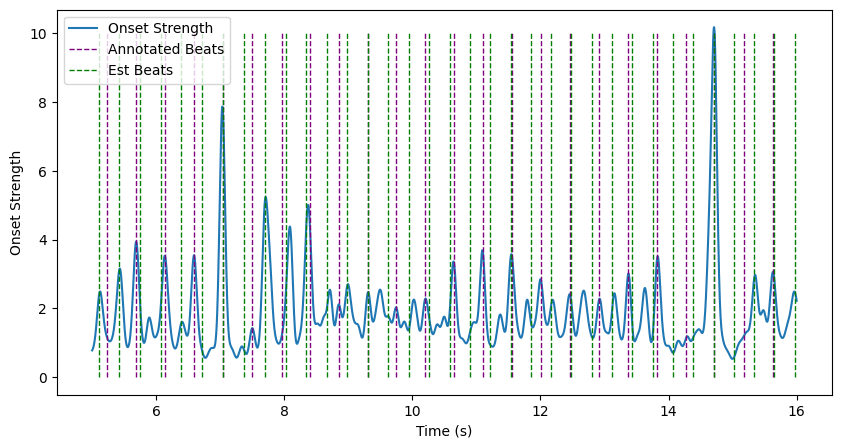

In [118]:
onset_strength_plt = bt.onset_env[1250:4000]
ref_beats_plt = ref_beats_trimmed
beats_plt = beats_trimmed

# ref_down_beats_plt = np.round(ref_down_beats*bt.frame_rate)-4000

x = [(i+1)/bt.frame_rate for i in range(1250, 4000)]

plt.figure(figsize=(10, 5))
plt.plot(x, onset_strength_plt)
plt.vlines(x=ref_beats_plt[ref_beats_plt<16], ymin=0, ymax=10, colors='purple', ls='--', lw=1, label='beats')
plt.vlines(x=beats_plt[beats_plt<16], ymin=0, ymax=10, colors='green', ls='--', lw=1, label='beats')

plt.xlabel("Time (s)")
plt.ylabel("Onset Strength")
plt.legend(["Onset Strength", "Annotated Beats", "Est Beats"])
# plt.vlines(x=ref_down_beats_plt[ref_down_beats_plt>0], ymin=0, ymax=8, colors='green', ls='--', lw=1, label='down beats')


### Review Rumba-International beat detection example

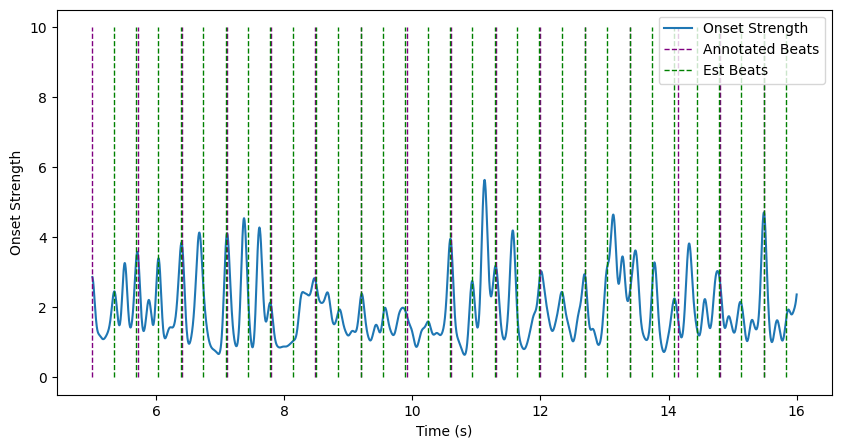

In [122]:
audio_filename = "BallroomData/Rumba-International/Albums-GloriaEstefan_MiTierra-01.wav"
beats_filename = "BallroomAnnotations-master/Albums-GloriaEstefan_MiTierra-01.beats"

bt = ellisBeatTracker(metric=4)
beats, downbeats = bt(audio_filename)
with open(beats_filename) as my_file:
    testsite_array = my_file.readlines()
    ref_beats = np.array([float(val.split()[0]) for val in testsite_array])
    ref_beat_count = np.array([float(val.split()[1]) for val in testsite_array])
    ref_down_beats = ref_beats[ref_beat_count==1]
    meter = int(ref_beat_count.max())

# Trim beats to 5 seconds and above
beats_trimmed = beat.trim_beats(beats, min_beat_time=5.0)
ref_beats_trimmed = beat.trim_beats(ref_beats, min_beat_time=5.0)
downbeats_trimmed = beat.trim_beats(downbeats, min_beat_time=5.0)
ref_down_beats_trimmed = beat.trim_beats(ref_down_beats, min_beat_time=5.0)

onset_strength_plt = bt.onset_env[1250:4000]
ref_beats_plt = ref_beats_trimmed
beats_plt = beats_trimmed


x = [(i+1)/bt.frame_rate for i in range(1250, 4000)]

plt.figure(figsize=(10, 5))
plt.plot(x, onset_strength_plt)
plt.vlines(x=ref_beats_plt[ref_beats_plt<16], ymin=0, ymax=10, colors='purple', ls='--', lw=1, label='beats')
plt.vlines(x=beats_plt[beats_plt<16], ymin=0, ymax=10, colors='green', ls='--', lw=1, label='beats')

plt.xlabel("Time (s)")
plt.ylabel("Onset Strength")
plt.legend(["Onset Strength", "Annotated Beats", "Est Beats"])
# plt.vlines(x=ref_down_beats_plt[ref_down_beats_plt>0], ymin=0, ymax=8, colors='green', ls='--', lw=1, label='down beats')


### Review Jive Downbeat detection example

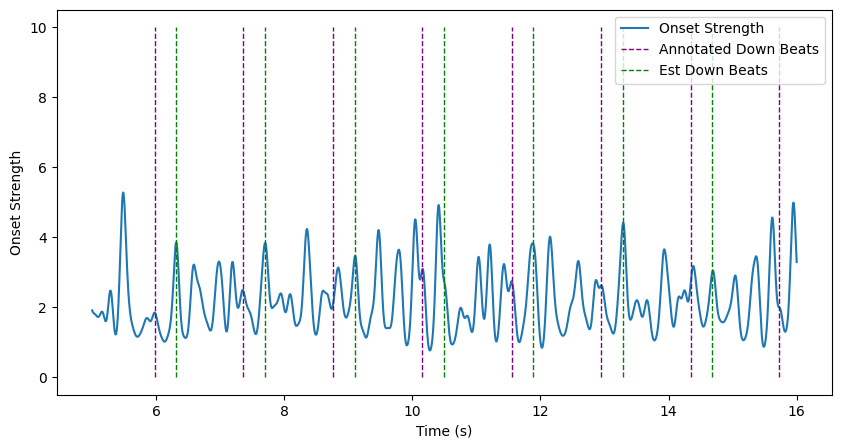

In [136]:
audio_filename = "BallroomData/Jive/Albums-Macumba-14.wav"
beats_filename = "BallroomAnnotations-master/Albums-Macumba-14.beats"

bt = ellisBeatTracker(metric=4)
beats, downbeats = bt(audio_filename)
with open(beats_filename) as my_file:
    testsite_array = my_file.readlines()
    ref_beats = np.array([float(val.split()[0]) for val in testsite_array])
    ref_beat_count = np.array([float(val.split()[1]) for val in testsite_array])
    ref_down_beats = ref_beats[ref_beat_count==1]
    meter = int(ref_beat_count.max())

# Trim beats to 5 seconds and above
beats_trimmed = beat.trim_beats(beats, min_beat_time=5.0)
ref_beats_trimmed = beat.trim_beats(ref_beats, min_beat_time=5.0)
downbeats_trimmed = beat.trim_beats(downbeats, min_beat_time=5.0)
ref_down_beats_trimmed = beat.trim_beats(ref_down_beats, min_beat_time=5.0)

onset_strength_plt = bt.onset_env[1250:4000]

x = [(i+1)/bt.frame_rate for i in range(1250, 4000)]

plt.figure(figsize=(10, 5))
plt.plot(x, onset_strength_plt)
plt.vlines(x=ref_down_beats_trimmed[ref_down_beats_trimmed<16], ymin=0, ymax=10, colors='purple', ls='--', lw=1, label='beats')
plt.vlines(x=downbeats_trimmed[downbeats_trimmed<16], ymin=0, ymax=10, colors='green', ls='--', lw=1, label='beats')
# plt.vlines(x=ref_beats_trimmed[ref_beats_trimmed<16], ymin=0, ymax=10, colors='green', ls='--', lw=1, label='beats')

plt.xlabel("Time (s)")
plt.ylabel("Onset Strength")
plt.legend(["Onset Strength", "Annotated Down Beats", "Est Down Beats"])
# plt.vlines(x=ref_down_beats_plt[ref_down_beats_plt>0], ymin=0, ymax=8, colors='green', ls='--', lw=1, label='down beats')
